# Decision Tree: Telecom Churn

In this assignment, we built a decision tree to predict the churn of high value customers.


In the following sections, we'll:
- clean and prepare the data, 
- build a decision tree with default hyperparameters, 
- understand all the hyperparameters that we can tune, and finally
- choose the optimal hyperparameters using grid search cross-validation.
- use logistic regression for feature selection.
- compare final models and seeing variables responsible for the churn


<hr>

### Understanding and Cleaning the Data

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Reading the csv file and putting it into 'df' object.
df = pd.read_csv('telecom_churn_data.csv')

In [4]:
# Let's understand the type of values in each column of our dataframe 'df'.
df.shape

(99999, 226)

In [5]:
# Let's understand the data, how it look like.
df.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6     ...      sachet_3g_9  fb_user_6  \
0            9/30/2014  197.385     ...                0        1.0   
1            9/30/2014   34.047     ...                0        NaN   
2            9/30/2014  167.690     ...                0        NaN   
3            9/30/2014  221.338     ...                0        NaN   
4            9/30/2014  261.636     ...                0        0.0   

   fb_user_7  fb_user_8  fb_user_9   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
0        1.0        1.0        NaN   968        30.4         0.0      101.20   
1        1.0        1.0        NaN  1006         0.0         0.0        0.00   
2        NaN        NaN        1.0  1103         0.0         0.0        4.17   
3        NaN        NaN        NaN  2491         0.0         0.0        0.00   
4        NaN        NaN        NaN  1526         0.0         0.0        0.00   

   sep_vbc_3g  
0        3.58  
1        0.00  
2        0.00  
3        0.00  
4        0.00  

[5 rows x 226 columns]

In [6]:
df['total_rech_amt_good_ph_avg'] = (df['total_rech_amt_6'] + df['total_rech_amt_7'])/2

## Filter High value customers

In [7]:
avg_rech_good_ph_70 = df['total_rech_amt_good_ph_avg'].quantile(0.7)

In [8]:
avg_rech_good_ph_70

368.5

In [9]:
df = df[df['total_rech_amt_good_ph_avg'] >= avg_rech_good_ph_70]

## Tag churners and remove attributes of the churn phase

In [10]:
#Checking Nulls for columns used for defining churner
print(df['total_ic_mou_9'].isnull().sum())
print(df['total_og_mou_9'].isnull().sum())
print(df['vol_2g_mb_9'].isnull().sum())
print(df['vol_3g_mb_9'].isnull().sum())

0
0
0
0


In [11]:
def churn (row):
    if((row['total_ic_mou_9'] == 0) & (row['total_og_mou_9'] == 0) & (row['vol_2g_mb_9'] == 0) & (row['vol_3g_mb_9'] == 0)) :
        return 1
    else:
        return 0

In [12]:
df['churn'] = df.apply(lambda row : churn(row), axis = 1)

In [13]:
df[['mobile_number','churn']].head()

mobile_number  churn
7      7000701601      1
8      7001524846      0
13     7002191713      0
16     7000875565      0
17     7000187447      0

In [14]:
# Remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names)
cols = [c for c in df.columns if c.lower()[-2:] != '_9']
df=df[cols]

In [15]:
# Remove all the date columns as they are not of use for the analysis
cols = [c for c in df.columns if 'date' not in c.lower()]
df=df[cols]

In [16]:
#These columns are having same values and hence won't contribute much to analysis, thus dropping them
cols=['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8']
df=df.drop(cols,axis=1)

In [17]:
df.head()

mobile_number    arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  \
7      7000701601  1069.180  1349.850  3171.480        57.84        54.68   
8      7001524846   378.721   492.223   137.362       413.69       351.03   
13     7002191713   492.846   205.671   593.260       501.76       108.39   
16     7000875565   430.975   299.869   187.894        50.51        74.01   
17     7000187447   690.008    18.980    25.499      1185.91         9.28   

    onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...    fb_user_6  \
7         52.29        453.43        567.16        325.91  ...          NaN   
8         35.08         94.66         80.63        136.48  ...          NaN   
13       534.24        413.31        119.28        482.46  ...          NaN   
16        70.61        296.29        229.74        162.76  ...          NaN   
17         7.79         61.64          0.00          5.54  ...          NaN   

    fb_user_7  fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
7         NaN        NaN   802       57.74       19.38       18.74   
8         1.0        1.0   315       21.03      910.65      122.16   
13        NaN        1.0  2607        0.00        0.00        0.00   
16        NaN        NaN   511        0.00        2.45       21.89   
17        NaN        NaN   667        0.00        0.00        0.00   

    sep_vbc_3g  total_rech_amt_good_ph_avg  churn  
7          0.0                      1185.0      1  
8          0.0                       519.0      0  
13         0.0                       380.0      0  
16         0.0                       459.0      0  
17         0.0                       408.0      0  

[5 rows x 155 columns]

In [18]:
df.shape

(30011, 155)

In [19]:
# Identifying columns with Nulls
round(df.isnull().sum()/len(df)*100,2).sort_values(ascending=False)

count_rech_3g_6               62.02
total_rech_data_6             62.02
av_rech_amt_data_6            62.02
count_rech_2g_6               62.02
max_rech_data_6               62.02
arpu_3g_6                     62.02
fb_user_6                     62.02
arpu_2g_6                     62.02
night_pck_user_6              62.02
count_rech_3g_7               61.14
av_rech_amt_data_7            61.14
max_rech_data_7               61.14
arpu_3g_7                     61.14
arpu_2g_7                     61.14
night_pck_user_7              61.14
count_rech_2g_7               61.14
total_rech_data_7             61.14
fb_user_7                     61.14
arpu_2g_8                     60.83
total_rech_data_8             60.83
max_rech_data_8               60.83
arpu_3g_8                     60.83
av_rech_amt_data_8            60.83
night_pck_user_8              60.83
count_rech_2g_8               60.83
count_rech_3g_8               60.83
fb_user_8                     60.83
loc_ic_t2f_mou_8            

In [20]:
# Identifying rows with nulls
df.isnull().sum(axis=1).sort_values(ascending=False)

5539     108
3506     108
4190     108
33857    108
30548    108
88185    108
32368    108
53460    108
89596    108
96449    108
78977    108
46858    108
52138    108
33018    108
14191    108
57525    108
30946    108
48177    108
74778    108
93234    108
89917    108
80932    108
40855     99
36807     99
88955     99
86889     99
90792     99
90850     99
19564     99
80564     99
        ... 
52052      0
52065      0
24195      0
24184      0
24228      0
52076      0
24182      0
52078      0
24161      0
73557      0
52088      0
73572      0
87766      0
87709      0
52015      0
24335      0
24324      0
73581      0
24295      0
24276      0
87741      0
24256      0
87764      0
52025      0
52026      0
24248      0
24245      0
24243      0
24235      0
99997      0
Length: 30011, dtype: int64

In [21]:
#dropping rows having more than 65% of data missing (i.e 100 columns empty)
df_new=df[df.isnull().sum(axis=1)<99]
print(len(df_new))

# Still we have more than 70% of data so we are good to drop from main df
df=df_new

29981


In [22]:
#Dropping columns having more than 60% of nulls
df=df.dropna(thresh=df.shape[0]*0.6,how='all',axis=1)

In [23]:
df.shape

(29981, 128)

In [24]:
# Filling NA in MOU columns with 0 
cols = [c for c in df.columns if 'mou' in c.lower()]
df[cols]= df[cols].fillna(0)

In [25]:
#Imputing values for ig/og others as 0 for the missing values
cols = ['og_others_8','ic_others_8','ic_others_6','og_others_6','ic_others_7','og_others_7']
df[cols]= df[cols].fillna(0)

In [26]:
df.head()

mobile_number    arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  \
7      7000701601  1069.180  1349.850  3171.480        57.84        54.68   
8      7001524846   378.721   492.223   137.362       413.69       351.03   
13     7002191713   492.846   205.671   593.260       501.76       108.39   
16     7000875565   430.975   299.869   187.894        50.51        74.01   
17     7000187447   690.008    18.980    25.499      1185.91         9.28   

    onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...    sachet_3g_6  \
7         52.29        453.43        567.16        325.91  ...              0   
8         35.08         94.66         80.63        136.48  ...              0   
13       534.24        413.31        119.28        482.46  ...              0   
16        70.61        296.29        229.74        162.76  ...              0   
17         7.79         61.64          0.00          5.54  ...              0   

    sachet_3g_7  sachet_3g_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
7             0            0   802       57.74       19.38       18.74   
8             0            0   315       21.03      910.65      122.16   
13            0            0  2607        0.00        0.00        0.00   
16            0            0   511        0.00        2.45       21.89   
17            0            0   667        0.00        0.00        0.00   

    sep_vbc_3g  total_rech_amt_good_ph_avg  churn  
7          0.0                      1185.0      1  
8          0.0                       519.0      0  
13         0.0                       380.0      0  
16         0.0                       459.0      0  
17         0.0                       408.0      0  

[5 rows x 128 columns]

In [27]:
# Identifying columns with Nulls
round(df.isnull().sum()/len(df)*100,2).sort_values(ascending=False).head()

churn                         0.0
total_rech_amt_good_ph_avg    0.0
std_og_t2t_mou_8              0.0
std_og_t2m_mou_6              0.0
std_og_t2m_mou_7              0.0
dtype: float64

In [28]:
# Identifying rows with nulls
df.isnull().sum(axis=1).sort_values(ascending=False).head()

99997    0
33257    0
33209    0
33211    0
33222    0
dtype: int64

Now we have a clean dataframe which is ready for model building.<br>

In [29]:
# clean dataframe
df.describe()

mobile_number        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count   2.998100e+04  29981.000000  29981.000000  29981.000000  29981.000000   
mean    7.001223e+09    586.877399    589.502239    535.243115    296.330683   
std     6.846663e+05    442.054122    462.825533    492.265870    460.910859   
min     7.000000e+09  -2258.709000  -2014.045000   -945.808000      0.000000   
25%     7.000641e+09    364.139000    365.257000    290.035000     41.280000   
50%     7.001232e+09    495.481000    493.679000    452.371000    125.940000   
75%     7.001814e+09    703.433000    700.845000    671.323000    353.580000   
max     7.002411e+09  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
count  29981.000000  29981.000000  29981.000000  29981.000000  29981.000000   
mean     304.647742    267.868182    418.351570    424.348568    375.396950   
std      481.925229    466.717487    470.638137    486.583757    477.580755   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       41.110000     27.180000    137.590000    136.040000     96.140000   
50%      125.640000     99.640000    282.440000    282.380000    241.280000   
75%      360.290000    298.240000    523.660000    532.980000    483.160000   
max     8157.780000  10752.560000   8362.360000   9667.130000  14007.340000   

           ...        sachet_3g_6   sachet_3g_7   sachet_3g_8           aon  \
count      ...       29981.000000  29981.000000  29981.000000  29981.000000   
mean       ...           0.138054      0.150362      0.140556   1264.010006   
std        ...           0.875955      0.969759      0.975205    975.154321   
min        ...           0.000000      0.000000      0.000000    180.000000   
25%        ...           0.000000      0.000000      0.000000    480.000000   
50%        ...           0.000000      0.000000      0.000000    914.000000   
75%        ...           0.000000      0.000000      0.000000   1923.000000   
max        ...          29.000000     35.000000     41.000000   4321.000000   

         aug_vbc_3g    jul_vbc_3g    jun_vbc_3g    sep_vbc_3g  \
count  29981.000000  29981.000000  29981.000000  29981.000000   
mean     129.511942    135.101802    121.114642      6.569244   
std      390.620357    407.956935    389.194803     48.662545   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000   
75%        1.660000      2.050000      0.000000      0.000000   
max    12916.220000   9165.600000  11166.210000   2618.570000   

       total_rech_amt_good_ph_avg         churn  
count                29981.000000  29981.000000  
mean                   696.719389      0.085521  
std                    488.931721      0.279660  
min                    368.500000      0.000000  
25%                    450.000000      0.000000  
50%                    568.500000      0.000000  
75%                    795.500000      0.000000  
max                  37762.500000      1.000000  

[8 rows x 128 columns]

In [30]:
#Percentage of churners
sum(df['churn'])/len(df)*100

#Clearly the class-imbalance is there

8.552082985891065

## Using oversampling to deal with class imbalance

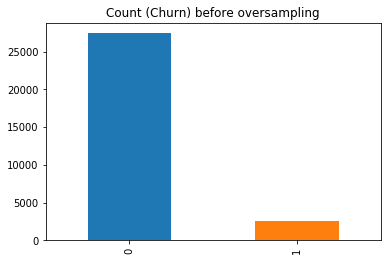

In [31]:
df.churn.value_counts().plot(kind='bar', title='Count (Churn) before oversampling');

Random over-sampling:
1    27417
0    27417
Name: churn, dtype: int64


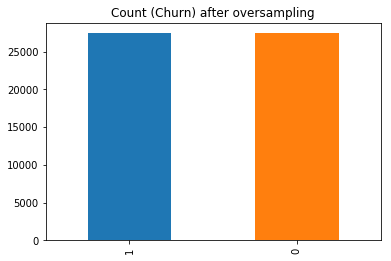

In [32]:
# Class count
count_class_0, count_class_1 = df['churn'].value_counts()

# Divide by class
df_class_0 = df[df['churn'] == 0]
df_class_1 = df[df['churn'] == 1]

#Oversampling
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_over.churn.value_counts())

df_over.churn.value_counts().plot(kind='bar', title='Count (Churn) after oversampling');

In [33]:
#New DF
df_over

mobile_number    arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  \
8         7001524846   378.721   492.223   137.362       413.69       351.03   
13        7002191713   492.846   205.671   593.260       501.76       108.39   
16        7000875565   430.975   299.869   187.894        50.51        74.01   
17        7000187447   690.008    18.980    25.499      1185.91         9.28   
21        7002124215   514.453   597.753   637.760       102.41       132.11   
24        7001125315   422.050   359.730   354.793       124.19        55.19   
33        7000149764   977.020  2362.833   409.230         0.00         0.00   
38        7000815202   363.987   486.558   393.909       248.99       619.96   
41        7000721289   482.832   425.764   229.769        86.39       118.88   
48        7000294396  1873.271   575.927   179.218      2061.69       881.43   
53        7002188521   978.077  1141.296   706.020       135.14       119.59   
56        7002180748   452.624   320.548   368.807        34.46        43.11   
57        7001682585  1201.298   687.704   602.052        61.23         7.39   
60        7000955945   410.261   430.205   289.228        62.24        85.68   
61        7000152517   565.516   390.307   430.911       178.41       226.81   
69        7002393996   809.518   794.775    33.060       181.63       257.06   
73        7002402996  2401.829  1873.764   722.368      2020.84      3220.46   
74        7001532600   324.449   382.389   350.360       381.23       635.28   
77        7001328263    30.000    82.378   674.950         0.00        34.23   
87        7001728145   623.635   712.818   560.995       162.68       133.49   
92        7001606600   465.794   530.596   463.903       178.46        92.96   
96        7001480390   676.999   786.560   377.488       113.24       360.04   
101       7001746121   512.524   402.001  1144.254       314.66       197.01   
102       7001631060   451.375   324.314   324.050        30.43        24.96   
103       7002236431   883.401  1082.027   759.027       253.98       287.11   
105       7000208415   659.587   398.875   621.127       995.39       453.39   
115       7001453769  1173.256   563.502   990.443        53.39        17.56   
122       7000973464   450.195   275.370   112.796       409.63       129.83   
124       7000302971   521.253   316.455   374.629       236.31       144.14   
131       7000720792   424.904   382.716   569.310        77.73       110.58   
...              ...       ...       ...       ...          ...          ...   
70572     7000557336  1149.460  1394.250  1464.350        76.74       105.33   
10295     7000549461   603.307   369.746   181.579       355.19       272.63   
24809     7000835020  1637.247  1455.207  1227.814      2593.11      2280.11   
15961     7000760293   840.443   240.738     0.600      1579.31       234.81   
63315     7000679620   596.603   172.001     6.000      1439.03       274.81   
13853     7002229391   525.555   231.818     5.000        13.53         1.94   
11069     7000851966   818.180   706.349   105.805       702.79       441.38   
67691     7001989706    57.490   573.531   875.561        14.93       391.68   
54609     7001985452   697.506    34.889     0.978       163.64        79.63   
84463     7000544884   481.749   461.799     0.000        18.19        25.23   
42871     7000665993   525.534   465.508   265.240       876.14       565.38   
47589     7002341524  1059.011   968.289    26.000       243.79       237.86   
62865     7000242070   955.645   566.594     0.000      1855.93      1110.09   
81893     7000633959   691.044   587.207     0.000       614.56       290.78   
66509     7001759927   825.146   453.771   471.117       362.21       119.46   
60870     7000764365   658.398   536.291     0.000        29.44        47.91   
98102     7000350528   433.063   430.811   184.540        33.24        13.96   
39684     7001024946   499.255   215.165     2.910        15.63         9.19   
37429  

In [34]:
#Importing the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [35]:
#Dropping non-PCA related columns
df_numeric = df_over.drop('churn',axis=1)
df_numeric.head()
normalized_df_numeric=(df_numeric-df_numeric.mean())/df_numeric.std()
normalized_df_numeric

mobile_number    arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  \
8           0.481818 -0.509205 -0.169564 -0.571853     0.120882     0.072958   
13          1.422629 -0.274132 -0.777689  0.407377     0.287274    -0.405206   
16         -0.434183 -0.401573 -0.577781 -0.463314    -0.565277    -0.472957   
17         -1.404975  0.131979 -1.173887 -0.812125     1.579845    -0.600519   
21          1.327403 -0.229626  0.054393  0.502959    -0.467222    -0.358461   
24         -0.081838 -0.419956 -0.450743 -0.104830    -0.426073    -0.510045   
33         -1.458138  0.723162  3.800268  0.012096    -0.660706    -0.618807   
38         -0.519343 -0.539554 -0.181587 -0.020812    -0.190287     0.602930   
41         -0.651835 -0.294759 -0.310605 -0.373371    -0.497489    -0.384533   
48         -1.254093  2.569246  0.008073 -0.481950     3.234465     1.118202   
53          1.418126  0.725339  1.207907  0.649575    -0.405385    -0.383134   
56          1.407159 -0.356980 -0.533895 -0.074729    -0.595601    -0.533851   
57          0.704355  1.185126  0.245288  0.426261    -0.545024    -0.604243   
60         -0.320784 -0.444239 -0.301180 -0.245658    -0.543116    -0.449959   
61         -1.454254 -0.124447 -0.385852  0.058665    -0.323635    -0.171839   
69          1.708008  0.378144  0.472515 -0.795884    -0.317551    -0.112226   
73          1.720705  3.657961  2.762359  0.684689     3.157287     5.727659   
74          0.492757 -0.620993 -0.402656 -0.114352     0.059555     0.633121   
77          0.204480 -1.227495 -1.039343  0.582840    -0.660706    -0.551350   
87          0.768630 -0.004735  0.298585  0.338074    -0.353354    -0.355742   
92          0.597156 -0.329853 -0.088129  0.129529    -0.323540    -0.435613   
96          0.419099  0.105184  0.455081 -0.056083    -0.446761     0.090714   
101         0.793991 -0.233599 -0.361035  1.590864    -0.066216    -0.230565   
102         0.631664 -0.359553 -0.525903 -0.170863    -0.603215    -0.569619   
103         1.485717  0.530327  1.082125  0.763430    -0.180860    -0.053007   
105        -1.375394  0.069319 -0.367669  0.467232     1.219894     0.274676   
115         0.381543  1.127366 -0.018295  1.260491    -0.559836    -0.584202   
122        -0.296068 -0.361984 -0.629773 -0.624618     0.113212    -0.362954   
124        -1.241995 -0.215620 -0.542581 -0.062224    -0.214244    -0.334754   
131        -0.652536 -0.414078 -0.401962  0.355934    -0.513850    -0.400890   
...              ...       ...       ...       ...          ...          ...   
70572      -0.883139  1.078351  1.744729  2.278402    -0.515721    -0.411236   
10295      -0.894249 -0.046606 -0.429487 -0.476879     0.010358    -0.081543   
24809      -0.491384  2.083087  1.874092  1.770344     4.238482     3.874539   
15961      -0.596808  0.441843 -0.703269 -0.865606     2.323100    -0.156073   
63315      -0.710621 -0.060415 -0.849144 -0.854007     2.058067    -0.077247   
13853       1.475785 -0.206758 -0.722199 -0.856155    -0.635144    -0.614983   
11069      -0.467477  0.395986  0.284856 -0.639635     0.667082     0.251008   
67691       1.137639 -1.170871  0.002988  1.013735    -0.632499     0.153066   
54609       1.131637  0.147424 -1.140124 -0.864794    -0.351540    -0.461882   
84463      -0.900706 -0.296989 -0.234131 -0.866894    -0.626340    -0.569087   
42871      -0.729846 -0.206802 -0.226259 -0.297182     0.994594     0.495371   
47589       1.633981  0.892046  0.840749 -0.811049    -0.200112    -0.150063   
62865      -1.327914  0.679134 -0.011733 -0.866894     2.845721     1.568815   
81893      -0.775039  0.134113  0.032012 -0.866894     0.500388    -0.045775   
66509       0.813468  0.410334 -0.251168  0.145024     0.023620    -0.383390   
60870      -0.591064  0.066870 -0.076043 -0.866894    -0.605085    -0.524392   
98102      -1.174902 -0.397272 -0.299894 -0.470519    -0.597906    -0.591296   
39684      -0.223438 -0.260931 -0.757540 -0.860644    -0.631177    -0.600696   
37429  

In [36]:
#Doing the PCA on the data
pca.fit_transform(normalized_df_numeric)

array([[-1.93524439e+00, -9.37154132e-01,  1.21667510e-04, ...,
         4.66404998e-06, -2.30307485e-06,  1.50581623e-13],
       [ 2.29369848e+00, -3.52385629e-01, -1.13882991e+00, ...,
         7.54221871e-06, -9.90139288e-07,  3.76614271e-14],
       [-3.88735007e-01, -2.08241924e+00, -1.14022189e+00, ...,
        -5.50006362e-06,  8.21393927e-06,  5.11267847e-14],
       ...,
       [-1.39438515e+00, -1.69878862e+00, -1.27974511e+00, ...,
        -9.04595330e-06,  1.75324994e-07, -3.20218411e-16],
       [-3.71543273e+00, -2.05003479e-01, -8.68519010e-01, ...,
         6.30650846e-06, -2.56291267e-06,  5.05674561e-16],
       [-1.99073138e+00,  2.88045820e+00, -1.32898043e+00, ...,
         6.36567086e-06, -2.95098479e-06,  1.37871779e-16]])

#### Let's plot the principal components and try to make sense of them
- We'll plot original features on the first 2 principal components as axes

In [37]:
pca.components_

array([[ 2.75202096e-02,  9.40094326e-02,  1.48666082e-01, ...,
         4.79311533e-02,  2.77623786e-02,  1.44452630e-01],
       [-2.35655032e-02,  1.08717445e-01,  1.38776141e-01, ...,
        -6.69356218e-02, -1.36131511e-02,  1.47980896e-01],
       [-2.19485127e-03,  1.16161651e-01,  1.53861975e-01, ...,
         1.69024484e-01,  4.83311249e-02,  1.65496337e-01],
       ...,
       [ 3.91703362e-08, -3.10140947e-07,  1.32366427e-08, ...,
        -1.63904400e-09, -5.33921286e-11,  1.31840919e-07],
       [ 1.69228568e-08,  3.04720582e-07, -3.50517093e-07, ...,
         2.04943367e-08,  1.46432095e-08,  5.12944968e-08],
       [ 2.60856189e-17, -2.18454596e-17,  2.51465249e-17, ...,
        -8.32055095e-17,  1.70129221e-17,  7.58449786e-01]])

In [38]:
colnames = list(normalized_df_numeric.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df

PC1       PC2                     Feature
0    0.027520 -0.023566               mobile_number
1    0.094009  0.108717                      arpu_6
2    0.148666  0.138776                      arpu_7
3    0.178247  0.099105                      arpu_8
4    0.013184  0.160410                 onnet_mou_6
5    0.045820  0.191812                 onnet_mou_7
6    0.081141  0.163085                 onnet_mou_8
7    0.058488  0.132314                offnet_mou_6
8    0.098851  0.162458                offnet_mou_7
9    0.138444  0.124653                offnet_mou_8
10   0.001368  0.005802               roam_ic_mou_6
11   0.000771  0.005890               roam_ic_mou_7
12   0.007911  0.018131               roam_ic_mou_8
13  -0.005002  0.023317               roam_og_mou_6
14  -0.004131  0.031031               roam_og_mou_7
15   0.010476  0.042903               roam_og_mou_8
16   0.098632 -0.015268            loc_og_t2t_mou_6
17   0.119861 -0.001583            loc_og_t2t_mou_7
18   0.125190 -0.003315            loc_og_t2t_mou_8
19   0.147363 -0.055512            loc_og_t2m_mou_6
20   0.172241 -0.042832            loc_og_t2m_mou_7
21   0.182878 -0.044323            loc_og_t2m_mou_8
22   0.076786 -0.046444            loc_og_t2f_mou_6
23   0.084513 -0.048202            loc_og_t2f_mou_7
24   0.090055 -0.051170            loc_og_t2f_mou_8
25   0.008166  0.027742            loc_og_t2c_mou_6
26   0.010411  0.044565            loc_og_t2c_mou_7
27   0.025357  0.038097            loc_og_t2c_mou_8
28   0.163442 -0.048901                loc_og_mou_6
29   0.193861 -0.032486                loc_og_mou_7
..        ...       ...                         ...
97   0.072983 -0.036293              max_rech_amt_6
98   0.082149 -0.022623              max_rech_amt_7
99   0.126194 -0.013577              max_rech_amt_8
100  0.059698 -0.013884          last_day_rch_amt_6
101  0.077135 -0.011179          last_day_rch_amt_7
102  0.099082 -0.018454          last_day_rch_amt_8
103  0.005767 -0.037311                 vol_2g_mb_6
104  0.009533 -0.031438                 vol_2g_mb_7
105  0.020736 -0.027522                 vol_2g_mb_8
106  0.039654 -0.054252                 vol_3g_mb_6
107  0.051181 -0.054647                 vol_3g_mb_7
108  0.060452 -0.047664                 vol_3g_mb_8
109  0.026590 -0.057416                monthly_2g_6
110  0.035172 -0.053916                monthly_2g_7
111  0.039092 -0.050554                monthly_2g_8
112 -0.003697 -0.014558                 sachet_2g_6
113  0.002014 -0.007767                 sachet_2g_7
114  0.016822 -0.004525                 sachet_2g_8
115  0.039716 -0.056035                monthly_3g_6
116  0.052062 -0.054699                monthly_3g_7
117  0.060649 -0.052316                monthly_3g_8
118  0.003002 -0.008301                 sachet_3g_6
119  0.005670 -0.005398                 sachet_3g_7
120  0.014672 -0.001727                 sachet_3g_8
121  0.069396 -0.075787                         aon
122  0.069202 -0.060489                  aug_vbc_3g
123  0.060663 -0.066189                  jul_vbc_3g
124  0.047931 -0.066936                  jun_vbc_3g
125  0.027762 -0.013613                  sep_vbc_3g
126  0.144453  0.147981  total_rech_amt_good_ph_avg

[127 rows x 3 columns]

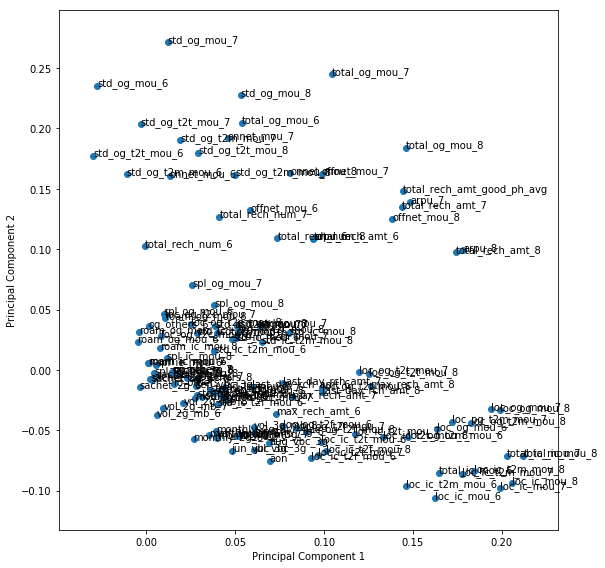

In [39]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

#### Looking at the screeplot to assess the number of needed principal components

In [40]:
pca.explained_variance_ratio_

array([9.67255946e-02, 7.80812971e-02, 5.47667686e-02, 4.16585236e-02,
       3.87792869e-02, 3.45307193e-02, 3.37449990e-02, 2.84373357e-02,
       2.65112341e-02, 2.49585278e-02, 2.37736499e-02, 2.17881059e-02,
       2.04697424e-02, 1.99681236e-02, 1.91122387e-02, 1.80368920e-02,
       1.61865413e-02, 1.61174996e-02, 1.50230725e-02, 1.37705923e-02,
       1.36152420e-02, 1.34635958e-02, 1.17621924e-02, 1.14760062e-02,
       1.11405394e-02, 1.07036430e-02, 9.44006764e-03, 9.27715016e-03,
       8.96560351e-03, 8.82301126e-03, 8.50806579e-03, 8.35891395e-03,
       8.02699220e-03, 8.01548874e-03, 7.71749912e-03, 7.62009632e-03,
       7.50955876e-03, 7.27440368e-03, 6.78294188e-03, 6.39054878e-03,
       6.22370151e-03, 5.99308319e-03, 5.89363358e-03, 5.69507736e-03,
       5.43396063e-03, 5.22538732e-03, 5.13475670e-03, 4.91449009e-03,
       4.81850983e-03, 4.78563153e-03, 4.74765359e-03, 4.65025273e-03,
       4.44340228e-03, 4.23544686e-03, 4.21857696e-03, 4.10910658e-03,
      

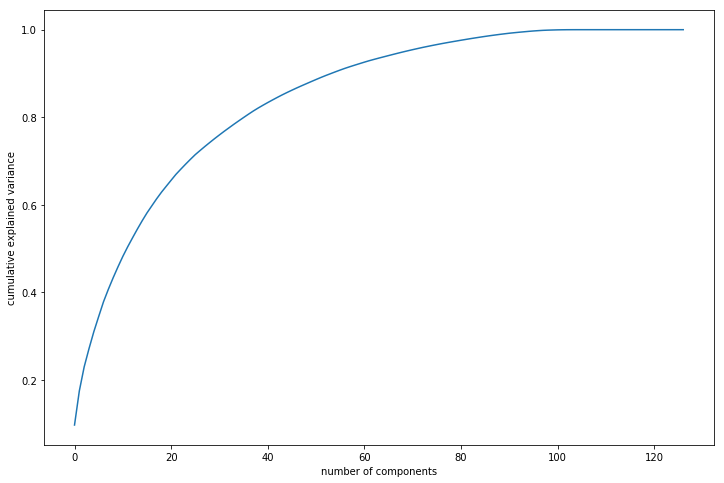

In [41]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

#### Looks like 70 components are enough to describe 95% of the variance in the dataset
- We'll choose 70 components for our modeling

In [42]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=70)

#### Basis transformation - getting the data onto our PCs

In [43]:
df_pca = pca_final.fit_transform(normalized_df_numeric)
df_pca.shape

(54834, 70)

In [44]:
principalDf = pd.DataFrame(data = df_pca)
principalDf = principalDf.add_prefix('pc_')
principalDf.head()

pc_0      pc_1      pc_2      pc_3      pc_4      pc_5      pc_6  \
0 -1.935120 -0.937193  0.000511 -0.959780 -1.644257  0.606899 -0.205141   
1  2.293859 -0.352202 -1.138516  6.167692 -0.635387 -1.320840  1.393912   
2 -0.388778 -2.082508 -1.140833  1.143297  0.424017 -0.690780  0.325218   
3 -3.950208 -0.368299 -0.954581 -0.340630  0.616779  1.159077  1.444577   
4 -0.097564  2.646438 -0.942252  0.774144 -0.543190 -1.428525 -2.900814   

       pc_7      pc_8      pc_9    ...        pc_60     pc_61     pc_62  \
0  0.742664 -0.014734 -0.632504    ...     0.374261 -0.030501  0.140803   
1  1.573313  0.202586  2.379472    ...     0.235782 -1.854193  0.476834   
2 -0.216580 -0.521707  0.463802    ...    -0.306672  0.364163 -0.169108   
3 -0.324937  0.197070  0.185163    ...    -0.148506  0.046508  0.290035   
4 -0.202220 -0.791571  0.726943    ...    -0.023078 -0.055316 -0.125304   

      pc_63     pc_64     pc_65     pc_66     pc_67     pc_68     pc_69  
0  0.038064  0.255781 -0.181383  0.367973 -0.147723 -0.896440 -0.221204  
1 -0.550417 -1.253483 -1.897687 -1.004719 -0.688524  1.757964 -0.887489  
2 -0.464726 -0.150399 -0.041692 -0.083708  0.315548 -0.014790 -0.153027  
3 -0.359322  0.046437  0.096971 -0.243474 -0.193801  0.179974 -0.096915  
4  0.036861 -0.084427  0.006164  0.168211 -0.010163 -0.136150  0.003402  

[5 rows x 70 columns]

#### Creating correlation matrix for the principal components - we expect little to no correlation

In [45]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(principalDf.transpose())

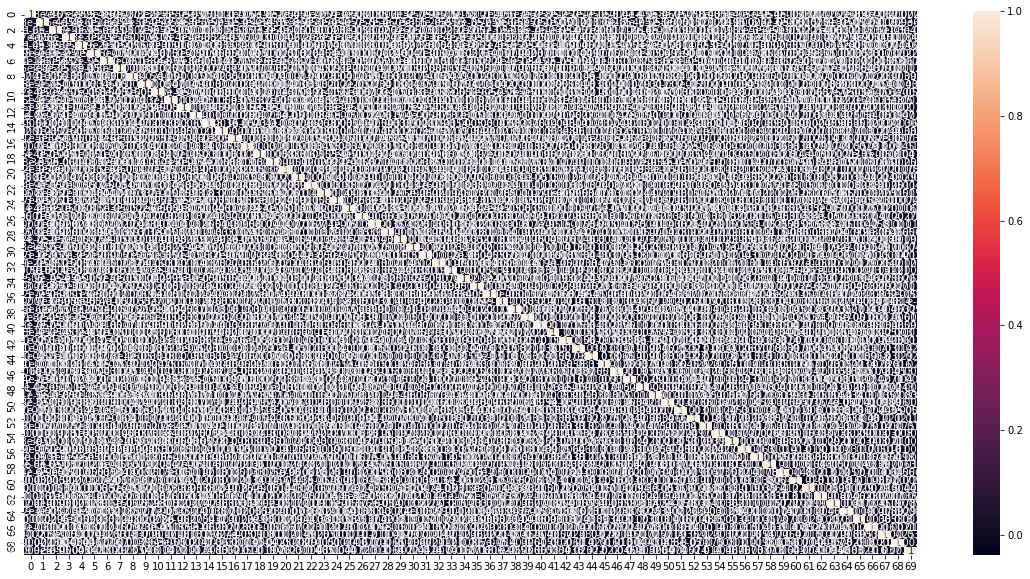

In [46]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

In [47]:
# 1s -> 0s in diagonals
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# we see that correlations are indeed very close to 0

max corr: 0.03554584032682791 , min corr:  -0.038309720696517384


In [48]:
principalDf.describe(percentiles=[.25,.5,.75,.90,.95,.99])

pc_0          pc_1          pc_2          pc_3          pc_4  \
count  5.483400e+04  5.483400e+04  5.483400e+04  5.483400e+04  5.483400e+04   
mean   2.316729e-15 -1.113989e-15  7.150019e-17  1.367385e-16  2.771893e-15   
std    3.504875e+00  3.149019e+00  2.637304e+00  2.300126e+00  2.219217e+00   
min   -4.250058e+00 -1.530725e+01 -2.103945e+01 -2.765322e+01 -2.804633e+01   
25%   -2.350565e+00 -1.993322e+00 -1.084263e+00 -6.781486e-01 -1.013293e+00   
50%   -9.124323e-01 -5.512751e-01 -4.974199e-01 -2.437890e-01  1.023045e-01   
75%    1.284994e+00  1.212074e+00  5.577958e-01  2.348319e-01  1.058321e+00   
90%    4.258843e+00  3.653335e+00  2.633376e+00  1.218939e+00  2.150896e+00   
95%    6.737457e+00  5.545771e+00  4.330456e+00  2.503803e+00  3.038396e+00   
99%    1.292903e+01  1.125725e+01  9.245390e+00  8.785980e+00  5.555354e+00   
max    9.308751e+01  7.091419e+01  1.173202e+02  9.007284e+01  7.716104e+01   

               pc_5          pc_6          pc_7          pc_8          pc_9  \
count  5.483400e+04  5.483400e+04  5.483400e+04  5.483400e+04  5.483400e+04   
mean  -2.967867e-15  7.990831e-16 -9.032786e-17 -7.737384e-17 -3.358979e-16   
std    2.094125e+00  2.070167e+00  1.900358e+00  1.834577e+00  1.780283e+00   
min   -2.361501e+01 -3.297209e+01 -2.790813e+01 -1.756119e+01 -5.721582e+01   
25%   -1.192731e+00 -9.348096e-01 -7.770891e-01 -6.113774e-01 -4.839587e-01   
50%   -1.474152e-01  3.552611e-02 -1.853629e-01 -7.226319e-02  2.087621e-01   
75%    1.009700e+00  9.619342e-01  5.895699e-01  4.946382e-01  7.086151e-01   
90%    2.318838e+00  2.054645e+00  1.747865e+00  1.341080e+00  1.175690e+00   
95%    3.375005e+00  2.968617e+00  2.809243e+00  2.085912e+00  1.591911e+00   
99%    6.150268e+00  5.764602e+00  5.816675e+00  5.256257e+00  3.459148e+00   
max    2.610428e+01  3.360465e+01  9.830105e+01  9.141331e+01  1.153251e+02   

           ...              pc_60         pc_61         pc_62         pc_63  \
count      ...       5.483400e+04  5.483400e+04  5.483400e+04  5.483400e+04   
mean       ...       1.698057e-17 -4.054762e-17 -1.480814e-17 -2.091640e-17   
std        ...       6.253001e-01  6.117766e-01  5.988881e-01  5.933641e-01   
min        ...      -1.572188e+01 -1.754542e+01 -1.466665e+01 -1.681958e+01   
25%        ...      -1.941475e-01 -1.641239e-01 -2.135844e-01 -2.195733e-01   
50%        ...       4.271858e-03 -5.705637e-03 -8.430146e-03 -5.839638e-03   
75%        ...       1.948860e-01  1.560407e-01  1.997112e-01  2.107124e-01   
90%        ...       4.573863e-01  4.014146e-01  5.452223e-01  5.223448e-01   
95%        ...       7.161119e-01  6.737748e-01  8.552013e-01  7.879062e-01   
99%        ...       1.598491e+00  1.591800e+00  1.660766e+00  1.675766e+00   
max        ...       2.262094e+01  3.291964e+01  1.568640e+01  2.117886e+01   

              pc_64         pc_65         pc_66         pc_67         pc_68  \
count  5.483400e+04  5.483400e+04  5.483400e+04  5.483400e+04  5.483400e+04   
mean   1.814939e-17 -5.061315e-17  1.369911e-17 -2.383095e-17  8.573017e-18   
std    5.809117e-01  5.852640e-01  5.674432e-01  5.577887e-01  5.387027e-01   
min   -1.747153e+01 -1.808405e+01 -1.858539e+01 -1.273761e+01 -1.036861e+01   
25%   -1.753873e-01 -1.479354e-01 -1.957204e-01 -1.654797e-01 -1.760936e-01   
50%    2.789465e-03 -7.026134e-03 -1.387467e-02  1.541151e-02  7.309919e-03   
75%    1.766383e-01  1.315539e-01  1.861535e-01  1.794496e-01  1.836426e-01   
90%    4.834459e-01  4.311297e-01  4.690257e-01  4.210702e-01  4.637074e-01   
95%    7.657836e-01  7.147249e-01  7.112640e-01  6.646983e-01  7.227714e-01   
99%    1.613660e+00  1.613654e+00  1.500151e+00  1.463563e+00  1.551737e+00   
max    1.486912e+01  1.816643e+01  2.260785e+01  1.858690e+01  1.329530e+01   

              pc_69  
count  5.483400e+04  
mean   4.121457e-17  
std    5.156285e-01  
min   -3.691945e+01  
25%   -1.504185e-01  
50%   -5.450871e-03  
75%    1.407880e-01  
90%    3.797796e-01  
95%    6.248281e-01  

In [49]:
principalDf.shape

(54834, 70)

In [50]:
from sklearn import preprocessing
imp = preprocessing.Imputer(missing_values=np.nan, strategy='mean')
df_pca = imp.fit_transform(principalDf)

In [51]:
df_final_pca=pd.DataFrame(df_pca)
df_final_pca=df_final_pca.reset_index(drop = True)
df_final_pca=df_final_pca.add_prefix('pc_')

In [52]:
#Adding Non PCA column back
df_final_pca['churn']=df_over['churn'].reset_index(drop = True)

In [53]:
df_final_pca

pc_0       pc_1       pc_2      pc_3      pc_4      pc_5  \
0      -1.935120  -0.937193   0.000511 -0.959780 -1.644257  0.606899   
1       2.293859  -0.352202  -1.138516  6.167692 -0.635387 -1.320840   
2      -0.388778  -2.082508  -1.140833  1.143297  0.424017 -0.690780   
3      -3.950208  -0.368299  -0.954581 -0.340630  0.616779  1.159077   
4      -0.097564   2.646438  -0.942252  0.774144 -0.543190 -1.428525   
5       0.687009  -1.996916  -1.028567  1.401338  0.706121 -1.769769   
6       2.645091  -3.418729  15.966491 -1.162553 -5.756208  7.234559   
7      -2.261026   1.210249  -0.414598 -0.357209 -1.463506 -1.072841   
8       0.114169  -2.528193   0.266369  0.700069  1.636194 -2.370817   
9       3.974898   1.341864  -2.915239 -1.601408  4.071831  5.237571   
10      4.584904  -0.511198  -0.052329  0.526483  2.169352  2.207907   
11     -0.798607  -2.648786   1.129570 -0.675354 -5.027272  2.188126   
12      5.147527  -4.808950  10.858969 -0.496065 -4.030304  5.424675   
13     -0.780583  -2.364188  -1.196982 -0.688079  0.295915 -0.904264   
14      5.156603  -4.995698  -3.046841  0.185333 -1.208539  0.378326   
15     -1.038817   2.795521  -1.152383  0.070228  2.695915  1.564108   
16      4.488181  15.936608  -1.758289 -1.237228  3.123375  6.467256   
17     -2.090476   0.678454  -0.545481 -0.110033 -1.287961 -1.272182   
18      0.124049  -2.490799   2.287702 -0.441065 -0.395898 -4.241146   
19      2.540905  -2.825985  -0.044614 -1.385416  0.319710 -1.800850   
20      1.126657  -2.358553  -1.023911 -0.676284 -0.965058 -0.179719   
21      0.161611   3.860994   0.836271  1.482231  2.001969 -1.498054   
22     -1.000112  -0.738416   3.275923  0.273081 -1.248460 -1.842891   
23     -0.619821  -0.858139   0.296963  0.310374 -0.558114 -1.670741   
24     11.673418   0.782281  -4.502530 -0.030562 -1.844946  2.142393   
25      3.923870  -1.882116  -0.490996 -2.567138 -1.011859  0.554083   
26     15.457693  -7.050395  -3.886465 -1.006062  1.626668  0.243537   
27     -3.501379  -0.473085   0.054479 -0.132658  0.132533 -0.696557   
28     -2.118857   0.401348  -0.724217  0.420540 -2.198004  0.794733   
29      1.864900  -2.438711  -0.622186 -1.159692  1.042570 -2.647325   
...          ...        ...        ...       ...       ...       ...   
54804   4.176648   1.571804   1.186504  4.815120  1.123110 -2.123905   
54805  -2.135338  -0.536914  -0.868646 -0.131843  0.252003  0.110415   
54806   1.602196  12.783419  -0.934555 -1.965587 -3.760817  2.734182   
54807  -3.588813   1.582017  -0.797967 -0.109817  1.107721  1.979618   
54808  -3.560692   0.454201  -0.904667  1.111084  0.526819  1.385026   
54809  -3.410891  -2.159001   0.036845 -0.245306  0.699671 -0.618425   
54810  -2.048321   2.282032  -0.641566  0.340782  1.800980  1.455361   
54811  -2.494826  -0.092351   2.784544 -0.225945  1.157339 -4.239151   
54812  -3.304725  -1.570585  -0.156022  1.064371  0.014758  0.991209   
54813  -2.584044   0.214331  -0.614955  0.114406  1.694662  0.231854   
54814  -2.407455   0.910845  -0.463394  0.155046 -0.124383  0.458525   
54815  -1.364299   2.839929  -0.141187 -0.440659  3.362839  1.286142   
54816  -2.823460   3.510276  -1.641468 -0.033839  0.174221  3.654434   
54817  -3.320364  -0.706571   0.768450 -0.301475  1.060744  0.143810   
54818  -2.924331  -0.496984   1.667041 -0.401446  1.362721 -1.376176   
54819  -0.297603  -2.614011  -2.006962 -0.078257  1.201140  1.508736   
54820  -1.835181  -1.967552  -0.313284 -0.330361 -2.441912  0.927277   
54821  -3.580236   0.077386  -0.415020 -0.035108  1.568278  0.112291   
54822  -3.828591  -0.642570  -0.547848  0.194183  1.379697  0.794775   
54823  -0.604236   4.492274   0.610094 -0.633262 -0.784900  0.708879   
54824  -1.080631   2.844620  -0.319603 -0.158998 -1.597880 -1.093483   
54825  -0.741410   3.069987  -0.479293 -0.271796  1.476935  1.268091   
54826   3.595843  -1.725074   0.339851 -0.498982 -1.177702 -0.191146   
54827   4.128549  -2.923090  -4.079442  0.776062  0.

# Scatter plot of PC

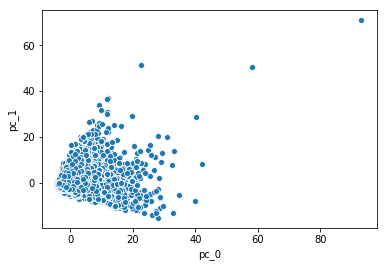

In [54]:
sns.scatterplot(df_final_pca['pc_0'],df_final_pca['pc_1'])

<hr>

### Model Building and Evaluation

Let's first build a decision tree with default hyperparameters. Then we'll use cross-validation to tune them.

In [55]:
# Importing train-test-split 
from sklearn.model_selection import train_test_split

In [56]:
# Putting feature variable to X
X = df_final_pca.drop('churn',axis=1)

# Putting response variable to y
y = df_final_pca['churn']

In [57]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, 
                                                    random_state = 99)
X_train.head()

pc_0      pc_1      pc_2      pc_3      pc_4      pc_5      pc_6  \
45243 -2.429874 -2.210672 -1.191309 -0.512038  0.729231  0.165802  0.492956   
38801 -1.909130 -2.504720 -1.358708 -0.613032  1.223308  0.427116  1.055461   
42174 -2.753623 -1.689283  1.145677  0.184193  1.979592 -2.179036  0.701713   
9388  -1.622279 -2.504327  0.914062 -0.440637  0.053915 -1.955727  0.307941   
36488 -1.752598 -1.003007 -1.359080 -0.871869  0.187198  0.546416 -1.040518   

           pc_7      pc_8      pc_9    ...        pc_60     pc_61     pc_62  \
45243 -0.123635 -0.307871  0.548524    ...    -0.013748 -0.020259 -0.179090   
38801 -0.419236 -0.258265  0.154850    ...    -0.207337  0.082533 -0.109674   
42174  1.267380 -1.483661 -1.388105    ...     0.229921 -0.080151  0.274471   
9388  -0.335988  0.040760  0.878171    ...     0.068891  0.159167 -0.184422   
36488  0.731331  0.874610 -0.462886    ...     0.307545 -0.014173 -0.371365   

          pc_63     pc_64     pc_65     pc_66     pc_67     pc_68     pc_69  
45243 -0.231493 -0.058435 -0.000085  0.012783  0.074225 -0.072934 -0.053738  
38801  0.222536  0.031141  0.073251  0.046763  0.065933  0.185645  0.182304  
42174  0.607600  0.000464 -0.016213 -0.024277 -0.189427  0.105973 -0.195788  
9388   0.092709 -0.080293  0.140836  0.028437  0.079592  0.382888  0.044298  
36488 -0.120533 -0.025178  0.408346  0.259623 -0.089129  0.262636 -0.056401  

[5 rows x 70 columns]

In [58]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt_default = DecisionTreeClassifier(max_depth=5)
dt_default.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [59]:
# Let's check the evaluation metrics of our default model

# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions
y_pred_default = dt_default.predict(X_test)

# Printing classification report
print(classification_report(y_test, y_pred_default))

             precision    recall  f1-score   support

          0       0.78      0.84      0.81      8188
          1       0.83      0.76      0.79      8263

avg / total       0.80      0.80      0.80     16451



In [60]:
# Printing confusion matrix and accuracy
print(confusion_matrix(y_test,y_pred_default))
print(accuracy_score(y_test,y_pred_default))

[[6886 1302]
 [1989 6274]]
0.7999513707373412


<hr>

### Plotting the Decision Tree

To visualise decision trees in python, you need to install certain external libraries. You can read about the process in detail here: http://scikit-learn.org/stable/modules/tree.html

We need the ```graphviz``` library to plot a tree.

In [61]:
# Importing required packages for visualization
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

# Putting features
features = list(df_final_pca.columns[:-1])
features

['pc_0',
 'pc_1',
 'pc_2',
 'pc_3',
 'pc_4',
 'pc_5',
 'pc_6',
 'pc_7',
 'pc_8',
 'pc_9',
 'pc_10',
 'pc_11',
 'pc_12',
 'pc_13',
 'pc_14',
 'pc_15',
 'pc_16',
 'pc_17',
 'pc_18',
 'pc_19',
 'pc_20',
 'pc_21',
 'pc_22',
 'pc_23',
 'pc_24',
 'pc_25',
 'pc_26',
 'pc_27',
 'pc_28',
 'pc_29',
 'pc_30',
 'pc_31',
 'pc_32',
 'pc_33',
 'pc_34',
 'pc_35',
 'pc_36',
 'pc_37',
 'pc_38',
 'pc_39',
 'pc_40',
 'pc_41',
 'pc_42',
 'pc_43',
 'pc_44',
 'pc_45',
 'pc_46',
 'pc_47',
 'pc_48',
 'pc_49',
 'pc_50',
 'pc_51',
 'pc_52',
 'pc_53',
 'pc_54',
 'pc_55',
 'pc_56',
 'pc_57',
 'pc_58',
 'pc_59',
 'pc_60',
 'pc_61',
 'pc_62',
 'pc_63',
 'pc_64',
 'pc_65',
 'pc_66',
 'pc_67',
 'pc_68',
 'pc_69']

**Note**:<br>
Python requires library pydot and an external software graphviz to visualize the decision tree. If you are on wondows, you'll need to specify the path for the pydot library to access dot file from graphviz.

Please read the downloadable instructions to install graphviz. For Mac users, one way is to:
- Install the python graphviz module: ```pip install graphviz```
- Then install the Graphviz software on Mac, you do this using homebrew:
    - Install homebrew: https://docs.brew.sh/Installation
    - ```brew install graphviz```

In [62]:
# If you're on windows:
# Specifing path for dot file.
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/graphviz-2.38/release/bin/'

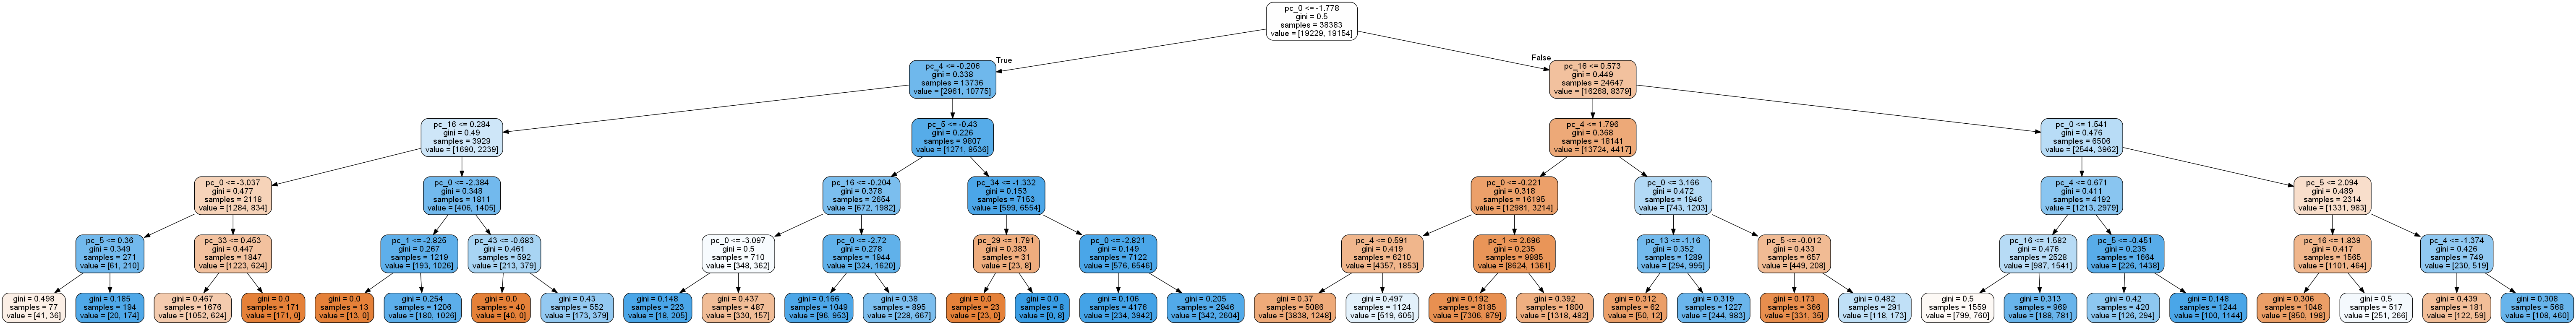

In [63]:
# plotting tree with max_depth=3
dot_data = StringIO()  
export_graphviz(dt_default, out_file=dot_data,
                feature_names=features, filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

<hr>

### Hyperparameter Tuning

The default tree is quite complex, and we need to simplify it by tuning the hyperparameters. 

First, let's understand the parameters in a decision tree. You can read this in the documentation using ```help(DecisionTreeClassifier)```.


- **criterion** (Gini/IG or entropy): It defines the function to measure the quality of a split. Sklearn supports “gini” criteria for Gini Index & “entropy” for Information Gain. By default, it takes the value “gini”.
- **splitter**: It defines the strategy to choose the split at each node. Supports “best” value to choose the best split & “random” to choose the best random split. By default, it takes “best” value.
- **max_features**: It defines the no. of features to consider when looking for the best split. We can input integer, float, string & None value.
    - If an integer is inputted then it considers that value as max features at each split.
    - If float value is taken then it shows the percentage of features at each split.
    - If “auto” or “sqrt” is taken then max_features=sqrt(n_features).
    - If “log2” is taken then max_features= log2(n_features).
    - If None, then max_features=n_features. By default, it takes “None” value.
- **max_depth**: The max_depth parameter denotes maximum depth of the tree. It can take any integer value or None. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. By default, it takes “None” value.
- **min_samples_split**: This tells above the minimum no. of samples reqd. to split an internal node. If an integer value is taken then consider min_samples_split as the minimum no. If float, then it shows percentage. By default, it takes “2” value.
- **min_samples_leaf**: The minimum number of samples required to be at a leaf node. If an integer value is taken then consider - -min_samples_leaf as the minimum no. If float, then it shows percentage. By default, it takes “1” value.
- **max_leaf_nodes**: It defines the maximum number of possible leaf nodes. If None then it takes an unlimited number of leaf nodes. By default, it takes “None” value.
- **min_impurity_split**: It defines the threshold for early stopping tree growth. A node will split if its impurity is above the threshold otherwise it is a leaf.<br>



<hr>

### Tuning max_depth

Let's first try to find the optimum values for max_depth and understand how the value of max_depth affects the decision tree.

Here, we are creating a dataframe with max_depth in range 1 to 80 and checking the accuracy score corresponding to each max_depth. 

To reiterate, a grid search scheme consists of:

    - an estimator (classifier such as SVC() or decision tree)
    - a parameter space
    - a method for searching or sampling candidates (optional) 
    - a cross-validation scheme, and
    - a score function (accuracy, roc_auc etc.)

In [64]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 40)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [65]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.298212      0.057372         0.002199        0.002855   
1       0.601756      0.024666         0.003694        0.000594   
2       0.826014      0.019380         0.004198        0.002924   
3       0.991513      0.127194         0.005924        0.005190   
4       1.273280      0.172378         0.004970        0.005804   

  param_max_depth            params  split0_test_score  split1_test_score  \
0               1  {'max_depth': 1}           0.705354           0.701316   
1               2  {'max_depth': 2}           0.738961           0.736876   
2               3  {'max_depth': 3}           0.764491           0.775042   
3               4  {'max_depth': 4}           0.785984           0.791716   
4               5  {'max_depth': 5}           0.805523           0.803309   

   split2_test_score  split3_test_score       ...         mean_test_score  \
0           0.710043           0.703791       ...                0.704322   
1           0.745734           0.743389       ...                0.740067   
2           0.772698           0.770223       ...                0.770523   
3           0.790022           0.791455       ...                0.789204   
4           0.813078           0.803309       ...                0.804601   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0        0.003269               39            0.704357            0.705367   
1        0.003913               38            0.740670            0.743112   
2        0.003514               37            0.775093            0.771185   
3        0.002366               36            0.791083            0.791930   
4        0.004950               35            0.807367            0.805608   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.708265            0.709829            0.702390   
1            0.745783            0.740083            0.742608   
2            0.777014            0.776949            0.771884   
3            0.796945            0.796848            0.791878   
4            0.812284            0.809711            0.806630   

   mean_train_score  std_train_score  
0          0.706042         0.002680  
1          0.742451         0.002017  
2          0.774425         0.002469  
3          0.793737         0.002597  
4          0.808320         0.002399  

[5 rows x 21 columns]

Now let's visualize how train and test score changes with max_depth.

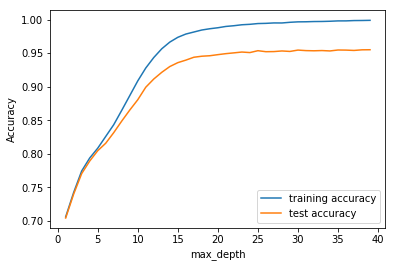

In [66]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


You can see that as we increase the value of max_depth, both training and test score increase till about max-depth = 10, after which the test score gradually reduces. Note that the scores are average accuracies across the 5-folds. 

Thus, it is clear that the model is overfitting the training data if the max_depth is too high. Next, let's see how the model behaves with other hyperparameters.

This shows that as you increase the min_samples_split, the tree overfits lesser since the model is less complex.

<hr>

## Grid Search to Find Optimal Hyperparameters

We can now use GridSearchCV to find multiple optimal hyperparameters together. Note that this time, we'll also specify the criterion (gini/entropy or IG).

In [67]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  2.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(5, 15, 5), 'min_samples_leaf': range(50, 150, 50), 'min_samples_split': range(50, 150, 50), 'criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [68]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.543645      0.111049         0.007245        0.007073   
1        1.517393      0.034753         0.001800        0.002227   
2        1.655907      0.174213         0.003003        0.002684   
3        1.802526      0.291871         0.002199        0.002856   
4        3.037657      0.405364         0.008852        0.006027   
5        3.299448      0.165306         0.005398        0.002870   
6        2.739957      0.189378         0.001799        0.002226   
7        2.596166      0.124195         0.005724        0.005233   
8        1.020020      0.031612         0.000803        0.001607   
9        1.016982      0.044067         0.007050        0.007148   
10       1.031160      0.055098         0.003925        0.006051   
11       0.991511      0.009671         0.003925        0.006052   
12       1.834076      0.134892         0.003203        0.002787   
13       1.970286      0.090344         0.002399        0.001959   
14       1.975780      0.272161         0.000000        0.000000   
15       1.676187      0.068171         0.001999        0.002529   

   param_criterion param_max_depth param_min_samples_leaf  \
0          entropy               5                     50   
1          entropy               5                     50   
2          entropy               5                    100   
3          entropy               5                    100   
4          entropy              10                     50   
5          entropy              10                     50   
6          entropy              10                    100   
7          entropy              10                    100   
8             gini               5                     50   
9             gini               5                     50   
10            gini               5                    100   
11            gini               5                    100   
12            gini              10                     50   
13            gini              10                     50   
14            gini              10                    100   
15            gini              10                    100   

   param_min_samples_split                                             params  \
0                       50  {'criterion': 'entropy', 'max_depth': 5, 'min_...   
1                      100  {'criterion': 'entropy', 'max_depth': 5, 'min_...   
2                       50  {'criterion': 'entropy', 'max_depth': 5, 'min_...   
3                      100  {'criterion': 'entropy', 'max_depth': 5, 'min_...   
4                       50  {'criterion': 'entropy', 'max_depth': 10, 'min...   
5                      100  {'criterion': 'entropy', 'max_depth': 10, 'min...   
6                       50  {'criterion': 'entropy', 'max_depth': 10, 'min...   
7                      100  {'criterion': 'entropy', 'max_depth': 10, 'min...   
8                       50  {'criterion': 'gini', 'max_depth': 5, 'min_sam...   
9                      100  {'criterion': 'gini', 'max_depth': 5, 'min_sam...   
10                      50  {'criterion': 'gini', 'max_depth': 5, 'min_sam...   
11                     100  {'criterion': 'gini', 'max_depth': 5, 'min_sam...   
12                      50  {'criterion': 'gini', 'max_depth': 10, 'min_sa...   
13                     100  {'criterion': 'gini', 'max_depth': 10, 'min_sa...   
14                      50  {'criterion': 'gini', 'max_depth': 10, 'min_sa...   
15                     100  {'criterion': 'gini', 'max_depth': 10, 'min_sa...   

    split0_test_score       ...         mean_test_score  std_test_score  \
0            0.796405       ...                0.797488        0.002714   
1            0.796405       ...                0.797488        0.002714   
2            0.796405       ...                0.797254        0.002102   
3            0.796405       ...                0.797254        0.002102   
4            0.839521       ...                0.841414 

In [69]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

best accuracy 0.8437068493864471
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


<hr>

**Running the model with best parameters obtained from grid search.**

In [70]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "entropy", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=100)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [71]:
# accuracy score
clf_gini.score(X_test,y_test)

0.8493708589143517

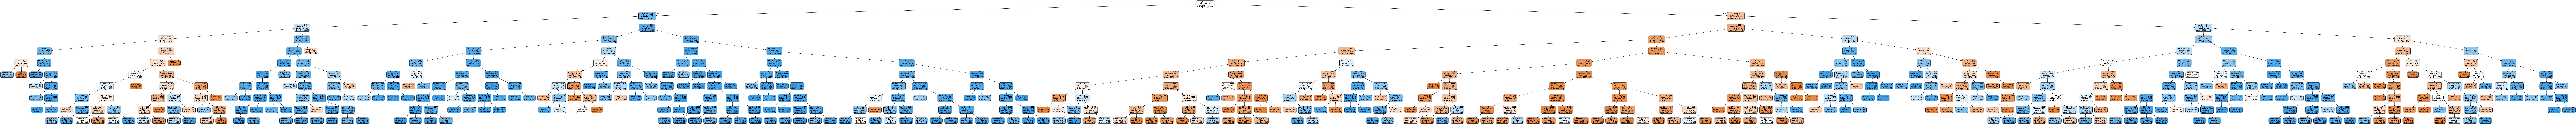

In [72]:
# plotting the tree
dot_data = StringIO()  
export_graphviz(clf_gini, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

You can see that this tree is too complex to understand. Let's try reducing the max_depth and see how the tree looks.

In [73]:
# tree with max_depth = 3
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=3, 
                                  min_samples_leaf=50,
                                  min_samples_split=100)
clf_gini.fit(X_train, y_train)

# score
print(clf_gini.score(X_test,y_test))

0.767734484225883


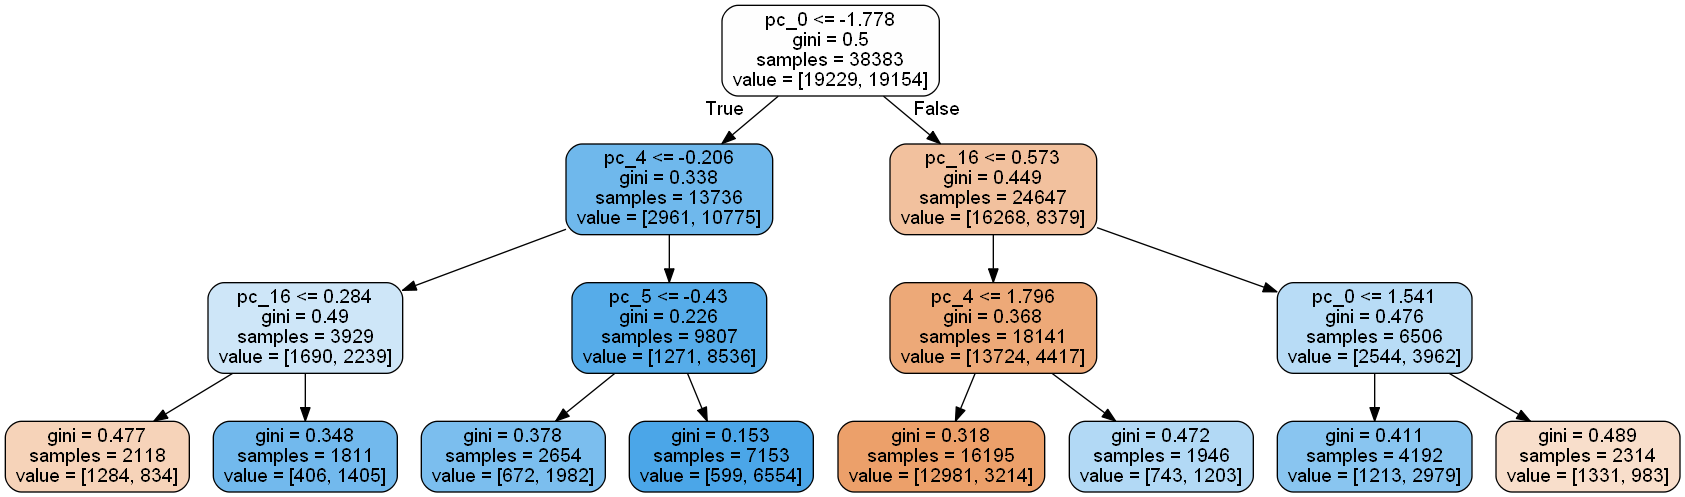

In [74]:
# plotting tree with max_depth=3
dot_data = StringIO()  
export_graphviz(clf_gini, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [75]:
# classification metrics
from sklearn.metrics import classification_report,confusion_matrix
y_pred = clf_gini.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.75      0.80      0.77      8188
          1       0.79      0.73      0.76      8263

avg / total       0.77      0.77      0.77     16451



In [76]:
# confusion %matplotlibrix
print(confusion_matrix(y_test,y_pred))

[[6559 1629]
 [2192 6071]]


# Feature Selection using Logistic Regresion

## Train-Test Split

In [77]:
from sklearn.model_selection import train_test_split

In [78]:
y = df_over.loc[:,'churn']
X = df_over.drop('churn',axis=1)

In [79]:
X_train, X_test,y_train,y_test = train_test_split(X,y,train_size=0.7, test_size=0.3, random_state=100)

In [80]:
X_train.head()

mobile_number    arpu_6    arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
85377     7001929955   314.450   514.447  315.838       118.49       161.34   
89309     7002323359  3342.679    66.000   66.000       306.69         0.00   
66727     7001118421   508.143   369.774   59.112       227.11       143.66   
98477     7000788442   479.958  1049.591  615.062       532.24       357.93   
13974     7002215229   999.864   628.597  590.276       939.63       327.89   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
85377       180.21        197.58        291.41        189.24   
89309         0.00        284.48          0.00          0.00   
66727        33.11        517.41        279.19         56.11   
98477       254.68        169.13         40.81         69.04   
13974       159.66         98.16        108.83         44.18   

                  ...              monthly_3g_8  sachet_3g_6  sachet_3g_7  \
85377             ...                         0            0            0   
89309             ...                         0            0            0   
66727             ...                         0            0            0   
98477             ...                         2            0            0   
13974             ...                         0            0            0   

       sachet_3g_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  sep_vbc_3g  \
85377            0  1434        0.00        0.00         0.0         0.0   
89309            0   763        0.00        0.00         0.0         0.0   
66727            0   368        0.00        0.00         0.0         0.0   
98477            0  1661      504.78      594.71         0.0         0.0   
13974            0  2603        0.00        0.00         0.0         0.0   

       total_rech_amt_good_ph_avg  
85377                       463.0  
89309                      1930.0  
66727                       522.0  
98477                       956.5  
13974                       896.5  

[5 rows x 127 columns]

## Feature Scaling

In [81]:
from sklearn.preprocessing import StandardScaler

In [82]:
scaler = StandardScaler()
X_train.iloc[:,:] = scaler.fit_transform(X_train)
X_test.iloc[:,:] = scaler.transform(X_test)
X_test.head()

mobile_number    arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  \
7313       -1.582673 -0.612049  1.076676  0.228497     0.171941     2.170104   
16662      -0.417559 -0.186018  0.099040  0.674853    -0.477711    -0.314886   
37046       1.390152 -0.227171 -0.227802  0.440053    -0.565257    -0.469773   
63364       0.555290  5.565754  7.422006  9.249743     0.100150     0.140218   
74545      -0.744369 -0.523243 -0.202324  0.205716    -0.356618    -0.324778   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
7313      0.966007     -0.675480      0.296808     -0.227405   
16662    -0.298730     -0.237428     -0.296920      0.234322   
37046    -0.111967      1.419099      1.256959      2.115570   
63364     0.749450      1.371751      1.374432      1.466971   
74545    -0.269484     -0.267875      0.735129      1.647694   

                  ...              monthly_3g_8  sachet_3g_6  sachet_3g_7  \
7313              ...                 -0.240913    -0.154464     -0.13865   
16662             ...                 -0.240913    -0.154464     -0.13865   
37046             ...                 -0.240913    -0.154464     -0.13865   
63364             ...                 12.900209    -0.154464     -0.13865   
74545             ...                 -0.240913    -0.154464     -0.13865   

       sachet_3g_8       aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  sep_vbc_3g  \
7313     -0.118772 -1.001996   -0.263888   -0.293869   -0.286946    -0.10173   
16662    -0.118772 -0.205825    1.291318    1.841078    0.087005     1.54498   
37046    -0.118772  0.696280   -0.263888   -0.293869   -0.286946    -0.10173   
63364    -0.118772 -0.387584    8.869997    7.928693    4.956897    -0.10173   
74545    -0.118772 -0.912789   -0.263888   -0.293869   -0.286946    -0.10173   

       total_rech_amt_good_ph_avg  
7313                     0.217628  
16662                   -0.122523  
37046                   -0.324993  
63364                    7.176534  
74545                   -0.440401  

[5 rows x 127 columns]

## Model Building

In [83]:
import statsmodels.api as sm

In [84]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38383
Model:                            GLM   Df Residuals:                    38256
Model Family:                Binomial   Df Model:                          126
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15332.
Date:                Mon, 13 May 2019   Deviance:                       30664.
Time:                        23:18:52   Pearson chi2:                 9.96e+04
No. Iterations:                     8   Covariance Type:             nonrobust
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -0.1679      0.018     -9.577      0.000      -0.202      -0.134
mobile_number                 -0.0054      0.015     -0.362      0.717      -0.035       0.024
arpu_6                         0.0062      0.064      0.097      0.923      -0.120       0.132
arpu_7                         0.2955      0.068      4.377      0.000       0.163       0.428
arpu_8                         0.7472      0.078      9.560      0.000       0.594       0.900
onnet_mou_6                   -4.6355      1.312     -3.533      0.000      -7.207      -2.064
onnet_mou_7                   -0.3240      1.095     -0.296      0.767      -2.471       1.823
onnet_mou_8                    1.5790      0.917      1.721      0.085      -0.219       3.377
offnet_mou_6                  -4.1967      1.364     -3.077      0.002      -6.870      -1.523
offnet_mou_7                  -1.5193      1.126     -1.350      0.177      -3.726       0.687
offnet_mou_8                   1.3745      0.924      1.487      0.137      -0.437       3.186
roam_ic_mou_6                  0.0996      0.032      3.134      0.002       0.037       0.162
roam_ic_mou_7                  0.0702      0.033      2.122      0.034       0.005       0.135
roam_ic_mou_8                 -0.0473      0.029     -1.642      0.101      -0.104       0.009
roam_og_mou_6                  1.3218      0.396      3.334      0.001       0.545       2.099
roam_og_mou_7                  0.4124      0.282      1.464      0.143      -0.140       0.964
roam_og_mou_8                 -0.4089      0.304     -1.344      0.179      -1.005       0.187
loc_og_t2t_mou_6            2735.7282    590.801      4.631      0.000    1577.779    3893.678
loc_og_t2t_mou_7            -496.3923    521.588     -0.952      0.341   -1518.685     525.900
loc_og_t2t_mou_8            5994.9550    486.501     12.323      0.000    5041.430    6948.480
loc_og_t2m_mou_6            2902.4152    626.891      4.630      0.000    1673.731    4131.099
loc_og_t2m_mou_7            -562.8388    591.701     -0.951      0.341   -1722.551     596.874
loc_og_t2m_mou_8            6734.1368    546.454     12.323      0.000    5663.107    7805.167
loc_og_t2f_mou_6             261.2774     56.432      4.630      0.000     150.672     371.882
loc_og_t2f_mou_7             -50.3754     52.815     -0.954      0.340    -153.891      53.140
loc_og_t2f_mou_8             550.1452     44.638     12.325      0.000     462.656     637.634
loc_og_t2c_mou_6              -0.0267      0.018     -1.458      0.145      -0.063       0.009
loc_og_t2c_mou_7               0.0240      0.023      1.057      0.291      -0.021       0.069
loc_og_t2c_mou_8               0.0446      0.020      2.220      0.026       0.005       0.084
loc_og_mou_6               -5899.6969   1162.051     -5.077      0.000   -8177.275   -3622.119
loc_og_mou_7               

## Feature Selection Using RFE

In [85]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [86]:
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 15)            
rfe = rfe.fit(X_train, y_train)

In [87]:
rfe.support_

array([False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False, False, False, False, False, False, False,  True,
       False])

In [88]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

col = X_train.columns[rfe.support_]

X_train.columns[~rfe.support_]

Index(['mobile_number', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_8',
       'roam_ic_mou_6',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'sachet_3g_6', 'sachet_3g_7',
       'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g',
       'total_rech_amt_good_ph_avg'],
      dtype='object', length=112)

##### Assessing the model with StatsModels

In [89]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38383
Model:                            GLM   Df Residuals:                    38367
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16957.
Date:                Mon, 13 May 2019   Deviance:                       33914.
Time:                        23:25:11   Pearson chi2:                 3.52e+05
No. Iterations:                     8   Covariance Type:             nonrobust
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.2835      0.016    -17.218      0.000      -0.316      -0.251
offnet_mou_7          -0.5206      0.062     -8.400      0.000      -0.642      -0.399
roam_og_mou_7          0.4177      0.021     20.241      0.000       0.377       0.458
std_og_t2t_mou_7      -0.4517      0.057     -7.979      0.000      -0.563      -0.341
std_og_mou_8           1.4946      0.073     20.407      0.000       1.351       1.638
total_og_mou_7         1.2569      0.083     15.103      0.000       1.094       1.420
total_og_mou_8        -2.4677      0.082    -30.130      0.000      -2.628      -2.307
loc_ic_t2m_mou_7       0.7065      0.036     19.726      0.000       0.636       0.777
loc_ic_t2m_mou_8      -1.0488      0.060    -17.612      0.000      -1.166      -0.932
total_ic_mou_8        -0.5145      0.039    -13.239      0.000      -0.591      -0.438
total_rech_num_8      -0.3620      0.019    -19.148      0.000      -0.399      -0.325
total_rech_amt_6       0.3742      0.019     19.791      0.000       0.337       0.411
last_day_rch_amt_8    -0.4289      0.018    -23.618      0.000      -0.464      -0.393
monthly_2g_8          -0.3963      0.020    -20.298      0.000      -0.435      -0.358
monthly_3g_8          -0.3287      0.020    -16.824      0.000      -0.367      -0.290
sep_vbc_3g            -0.8007      0.076    -10.498      0.000      -0.950      -0.651
======================================================================================
"""

In [90]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

85377    0.757915
89309    0.960990
66727    0.689991
98477    0.155500
13974    0.789799
84165    0.031779
10147    0.855739
88435    0.508228
6346     0.252936
74243    0.666157
dtype: float64

In [91]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.7579152 , 0.96098978, 0.6899912 , 0.15549989, 0.7897993 ,
       0.03177924, 0.85573907, 0.50822835, 0.25293611, 0.66615724])

In [92]:
y_train_pred_final = pd.DataFrame({'Churned':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final.head()

Churned  Churn_Prob
0        0    0.757915
1        1    0.960990
2        0    0.689991
3        0    0.155500
4        0    0.789799

##### Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

In [93]:
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

In [94]:
# Let's see the head
y_train_pred_final.head()

Churned  Churn_Prob  predicted
0        0    0.757915          1
1        1    0.960990          1
2        0    0.689991          1
3        0    0.155500          0
4        0    0.789799          1

In [95]:
from sklearn import metrics

In [96]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Churned, y_train_pred_final.predicted )
print(confusion)

[[15373  3813]
 [ 3204 15993]]


In [97]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Churned, y_train_pred_final.predicted))

0.8171846911393065


In [98]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [99]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
4       total_og_mou_7  20.38
0         offnet_mou_7  11.35
5       total_og_mou_8   9.86
2     std_og_t2t_mou_7   9.85
3         std_og_mou_8   8.83
7     loc_ic_t2m_mou_8   4.22
8       total_ic_mou_8   2.98
6     loc_ic_t2m_mou_7   2.27
9     total_rech_num_8   1.41
1        roam_og_mou_7   1.32
11  last_day_rch_amt_8   1.18
10    total_rech_amt_6   1.12
13        monthly_3g_8   1.07
12        monthly_2g_8   1.04
14          sep_vbc_3g   1.02

### Let's drop variables with high VIF one at a time

In [100]:
col = col.drop('total_og_mou_7', 1)
col

Index(['offnet_mou_7', 'roam_og_mou_7', 'std_og_t2t_mou_7', 'std_og_mou_8',
       'total_og_mou_8', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8',
       'total_ic_mou_8', 'total_rech_num_8', 'total_rech_amt_6',
       'last_day_rch_amt_8', 'monthly_2g_8', 'monthly_3g_8', 'sep_vbc_3g'],
      dtype='object')

In [101]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38383
Model:                            GLM   Df Residuals:                    38368
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17061.
Date:                Mon, 13 May 2019   Deviance:                       34123.
Time:                        23:25:13   Pearson chi2:                 7.68e+05
No. Iterations:                     8   Covariance Type:             nonrobust
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.2858      0.016    -17.439      0.000      -0.318      -0.254
offnet_mou_7           0.3692      0.020     18.220      0.000       0.330       0.409
roam_og_mou_7          0.2844      0.018     15.844      0.000       0.249       0.320
std_og_t2t_mou_7       0.3518      0.020     17.984      0.000       0.313       0.390
std_og_mou_8           1.0282      0.064     16.005      0.000       0.902       1.154
total_og_mou_8        -1.9301      0.071    -27.078      0.000      -2.070      -1.790
loc_ic_t2m_mou_7       0.7559      0.036     21.283      0.000       0.686       0.825
loc_ic_t2m_mou_8      -1.1980      0.059    -20.411      0.000      -1.313      -1.083
total_ic_mou_8        -0.4728      0.038    -12.427      0.000      -0.547      -0.398
total_rech_num_8      -0.3682      0.019    -19.482      0.000      -0.405      -0.331
total_rech_amt_6       0.3781      0.019     20.064      0.000       0.341       0.415
last_day_rch_amt_8    -0.4390      0.018    -25.040      0.000      -0.473      -0.405
monthly_2g_8          -0.3980      0.019    -20.423      0.000      -0.436      -0.360
monthly_3g_8          -0.3349      0.020    -17.095      0.000      -0.373      -0.297
sep_vbc_3g            -0.8099      0.076    -10.674      0.000      -0.959      -0.661
======================================================================================
"""

In [102]:
##### Let's check the VIFs again

vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
4       total_og_mou_8  6.76
3         std_og_mou_8  6.50
6     loc_ic_t2m_mou_8  4.09
7       total_ic_mou_8  2.96
5     loc_ic_t2m_mou_7  2.27
2     std_og_t2t_mou_7  1.49
0         offnet_mou_7  1.41
8     total_rech_num_8  1.41
10  last_day_rch_amt_8  1.18
9     total_rech_amt_6  1.12
1        roam_og_mou_7  1.10
12        monthly_3g_8  1.07
11        monthly_2g_8  1.04
13          sep_vbc_3g  1.02

In [104]:
col = col.drop('total_og_mou_8', 1)
col

Index(['offnet_mou_7', 'roam_og_mou_7', 'std_og_t2t_mou_7', 'std_og_mou_8',
       'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'total_ic_mou_8',
       'total_rech_num_8', 'total_rech_amt_6', 'last_day_rch_amt_8',
       'monthly_2g_8', 'monthly_3g_8', 'sep_vbc_3g'],
      dtype='object')

In [105]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38383
Model:                            GLM   Df Residuals:                    38369
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17564.
Date:                Mon, 13 May 2019   Deviance:                       35128.
Time:                        23:27:20   Pearson chi2:                 8.78e+08
No. Iterations:                     8   Covariance Type:             nonrobust
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.2951      0.016    -18.310      0.000      -0.327      -0.263
offnet_mou_7           0.2637      0.019     14.227      0.000       0.227       0.300
roam_og_mou_7          0.3370      0.018     19.188      0.000       0.303       0.371
std_og_t2t_mou_7       0.3414      0.019     17.929      0.000       0.304       0.379
std_og_mou_8          -0.5425      0.024    -22.462      0.000      -0.590      -0.495
loc_ic_t2m_mou_7       0.8324      0.035     23.941      0.000       0.764       0.901
loc_ic_t2m_mou_8      -1.7363      0.058    -29.825      0.000      -1.850      -1.622
total_ic_mou_8        -0.6881      0.040    -17.030      0.000      -0.767      -0.609
total_rech_num_8      -0.4445      0.019    -23.578      0.000      -0.481      -0.408
total_rech_amt_6       0.3420      0.018     19.252      0.000       0.307       0.377
last_day_rch_amt_8    -0.5052      0.018    -28.489      0.000      -0.540      -0.470
monthly_2g_8          -0.4004      0.019    -20.622      0.000      -0.438      -0.362
monthly_3g_8          -0.3202      0.019    -16.512      0.000      -0.358      -0.282
sep_vbc_3g            -0.8074      0.076    -10.632      0.000      -0.956      -0.659
======================================================================================
"""

In [106]:
##### Let's check the VIFs again

vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
5     loc_ic_t2m_mou_8  4.00
6       total_ic_mou_8  2.87
4     loc_ic_t2m_mou_7  2.27
3         std_og_mou_8  2.11
2     std_og_t2t_mou_7  1.49
0         offnet_mou_7  1.38
7     total_rech_num_8  1.36
9   last_day_rch_amt_8  1.15
8     total_rech_amt_6  1.11
1        roam_og_mou_7  1.08
11        monthly_3g_8  1.07
10        monthly_2g_8  1.04
12          sep_vbc_3g  1.02

In [107]:
col = col.drop('loc_ic_t2m_mou_8', 1)
col

Index(['offnet_mou_7', 'roam_og_mou_7', 'std_og_t2t_mou_7', 'std_og_mou_8',
       'loc_ic_t2m_mou_7', 'total_ic_mou_8', 'total_rech_num_8',
       'total_rech_amt_6', 'last_day_rch_amt_8', 'monthly_2g_8',
       'monthly_3g_8', 'sep_vbc_3g'],
      dtype='object')

In [108]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38383
Model:                            GLM   Df Residuals:                    38370
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18016.
Date:                Mon, 13 May 2019   Deviance:                       36032.
Time:                        23:27:53   Pearson chi2:                 3.45e+08
No. Iterations:                     8   Covariance Type:             nonrobust
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.2720      0.016    -17.274      0.000      -0.303      -0.241
offnet_mou_7           0.2875      0.018     15.709      0.000       0.252       0.323
roam_og_mou_7          0.3471      0.018     18.943      0.000       0.311       0.383
std_og_t2t_mou_7       0.3706      0.019     19.339      0.000       0.333       0.408
std_og_mou_8          -0.5425      0.024    -22.640      0.000      -0.590      -0.496
loc_ic_t2m_mou_7       0.3051      0.025     12.039      0.000       0.255       0.355
total_ic_mou_8        -1.6944      0.035    -48.269      0.000      -1.763      -1.626
total_rech_num_8      -0.4857      0.019    -25.679      0.000      -0.523      -0.449
total_rech_amt_6       0.3553      0.018     19.821      0.000       0.320       0.390
last_day_rch_amt_8    -0.5308      0.018    -28.833      0.000      -0.567      -0.495
monthly_2g_8          -0.4012      0.019    -20.911      0.000      -0.439      -0.364
monthly_3g_8          -0.3231      0.019    -16.778      0.000      -0.361      -0.285
sep_vbc_3g            -0.8086      0.075    -10.766      0.000      -0.956      -0.661
======================================================================================
"""

In [109]:
##### Let's check the VIFs again

vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
3         std_og_mou_8  2.10
5       total_ic_mou_8  1.66
4     loc_ic_t2m_mou_7  1.61
2     std_og_t2t_mou_7  1.49
0         offnet_mou_7  1.38
6     total_rech_num_8  1.35
8   last_day_rch_amt_8  1.14
7     total_rech_amt_6  1.11
1        roam_og_mou_7  1.08
10        monthly_3g_8  1.07
9         monthly_2g_8  1.03
11          sep_vbc_3g  1.02

In [113]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)

In [114]:
y_train_pred_final['Churn_Prob'] = y_train_pred

In [115]:
# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

Churned  Churn_Prob  predicted
0        0    0.633122          1
1        1    0.958612          1
2        0    0.619448          1
3        0    0.116073          0
4        0    0.636430          1

In [116]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Churned, y_train_pred_final.predicted))

0.8058515488627778


In [117]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [118]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8330989217065167

In [119]:
# Let us calculate specificity
TN / float(TN+FP)

0.8012613363911185

In [120]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.19873866360888148


In [121]:
# positive predictive value 
print (TP / float(TP+FP))

0.8074825810360496


In [122]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8275286644775798


## ROC Curve

In [123]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [124]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churned, y_train_pred_final.Churn_Prob, drop_intermediate = False )

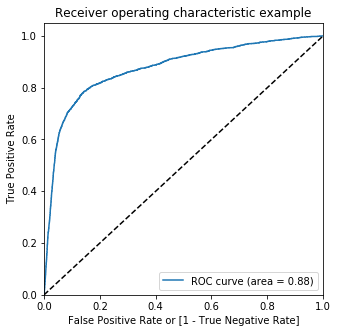

In [125]:
draw_roc(y_train_pred_final.Churned, y_train_pred_final.Churn_Prob)

## Finding Optimal Cutoff Point

In [126]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Churned  Churn_Prob  predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  \
0        0    0.633122          1    1    1    1    1    1    1    1    0   
1        1    0.958612          1    1    1    1    1    1    1    1    1   
2        0    0.619448          1    1    1    1    1    1    1    1    0   
3        0    0.116073          0    1    1    0    0    0    0    0    0   
4        0    0.636430          1    1    1    1    1    1    1    1    0   

   0.8  0.9  
0    0    0  
1    1    1  
2    0    0  
3    0    0  
4    0    0

In [127]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

In [128]:
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churned, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.500143  1.000000  0.000000
0.1   0.1  0.619884  0.968537  0.271031
0.2   0.2  0.679311  0.939470  0.419003
0.3   0.3  0.730480  0.908892  0.551965
0.4   0.4  0.769716  0.866906  0.672470
0.5   0.5  0.805852  0.825389  0.786303
0.6   0.6  0.817002  0.758191  0.875847
0.7   0.7  0.801084  0.673647  0.928594
0.8   0.8  0.711304  0.455227  0.967528
0.9   0.9  0.555897  0.119654  0.992390


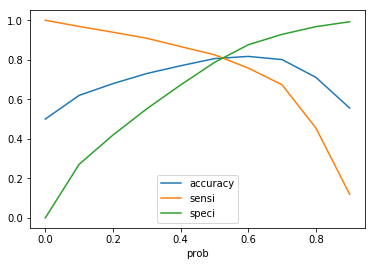

In [129]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [130]:
#### From the curve above, ~0.55 is the optimum point to take it as a cutoff probability.

y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.55 else 0)

y_train_pred_final.head()

Churned  Churn_Prob  predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  \
0        0    0.633122          1    1    1    1    1    1    1    1    0   
1        1    0.958612          1    1    1    1    1    1    1    1    1   
2        0    0.619448          1    1    1    1    1    1    1    1    0   
3        0    0.116073          0    1    1    0    0    0    0    0    0   
4        0    0.636430          1    1    1    1    1    1    1    1    0   

   0.8  0.9  final_predicted  
0    0    0                1  
1    1    1                1  
2    0    0                1  
3    0    0                0  
4    0    0                1

In [131]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Churned, y_train_pred_final.final_predicted)

0.8180183935596488

In [132]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Churned, y_train_pred_final.final_predicted )
confusion2

array([[16026,  3160],
       [ 3825, 15372]], dtype=int64)

In [133]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [134]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8007501172058135

In [135]:
# Let us calculate specificity
TN / float(TN+FP)

0.8352965704159283

In [136]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.16470342958407172


In [137]:
# positive predictive value 
print (TP / float(TP+FP))

0.8294841355493201


In [138]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8073144929726462


## Making predictions on the test set

In [139]:
X_test = X_test[col]
X_test.head()

offnet_mou_7  roam_og_mou_7  std_og_t2t_mou_7  std_og_mou_8  \
7313       0.296808      -0.268551          2.511039      0.874014   
16662     -0.296920       0.174331         -0.459528     -0.368218   
37046      1.256959      -0.268551         -0.325180      1.751494   
63364      1.374432      -0.268551         -0.309969      0.596324   
74545      0.735129      -0.268551         -0.259939      1.274321   

       loc_ic_t2m_mou_7  total_ic_mou_8  total_rech_num_8  total_rech_amt_6  \
7313          -0.334516        0.749991          4.318220         -0.627093   
16662          0.822229        1.926649         -0.353054         -0.333035   
37046         -0.318696       -0.340537          0.314271         -0.333035   
63364          1.034126        2.885803          0.759155          5.669802   
74545         -0.084553       -0.020981         -0.019391         -0.671033   

       last_day_rch_amt_8  monthly_2g_8  monthly_3g_8  sep_vbc_3g  
7313            -0.412396      -0.24474     -0.240913    -0.10173  
16662           -0.483349      -0.24474     -0.240913     1.54498  
37046           -0.128583      -0.24474     -0.240913    -0.10173  
63364            1.304672      -0.24474     12.900209    -0.10173  
74545            0.439043      -0.24474     -0.240913    -0.10173

In [140]:
X_test_sm = sm.add_constant(X_test)

In [141]:
#Making predictions on the test set
y_test_pred = res.predict(X_test_sm)

In [142]:
y_test_pred[:10]

7313     0.045679
16662    0.017217
37046    0.368368
63364    0.000329
74545    0.243142
2687     0.688953
84126    0.637175
1979     0.878556
63522    0.815436
46238    0.853478
dtype: float64

In [143]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

In [144]:
# Let's see the head
y_pred_1.head()

0
7313   0.045679
16662  0.017217
37046  0.368368
63364  0.000329
74545  0.243142

In [145]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [146]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [147]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [148]:
y_pred_final.head()

churn         0
0      1  0.045679
1      0  0.017217
2      0  0.368368
3      0  0.000329
4      0  0.243142

In [149]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Churn_Prob'})

In [150]:
# Let's see the head of y_pred_final
y_pred_final.head()

churn  Churn_Prob
0      1    0.045679
1      0    0.017217
2      0    0.368368
3      0    0.000329
4      0    0.243142

In [151]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.55 else 0)

In [152]:
y_pred_final.head()

churn  Churn_Prob  final_predicted
0      1    0.045679                0
1      0    0.017217                0
2      0    0.368368                0
3      0    0.000329                0
4      0    0.243142                0

In [153]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.churn, y_pred_final.final_predicted)

0.8192207160658926

In [154]:
confusion2 = metrics.confusion_matrix(y_pred_final.churn, y_pred_final.final_predicted )
confusion2

array([[6931, 1300],
       [1674, 6546]], dtype=int64)

In [155]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [156]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7963503649635036

In [157]:
# Let us calculate specificity
TN / float(TN+FP)

0.8420605029765521

# Conclusion

We have used PCA and decision tree for prediction and logistic regression for feature selection.


Following feautres can be used to identify the churn of the customer:

    std_og_mou_8
    total_ic_mou_8
    loc_ic_t2m_mou_7
    std_og_t2t_mou_7
    std_og_t2t_mou_7
    offnet_mou_7
    total_rech_num_8
    last_day_rch_amt_8
    total_rech_amt_6
    roam_og_mou_7
    monthly_3g_8
    monthly_2g_8
    sep_vbc_3g	

With LR we got 84% accuracy, 77% sensitivity and 77% specificity.

With Decision tree we got 84% accuracy, 76% precision, 76% recall and 76% gini score.